# Daniele Sindaco 0001139535

# FRUIT INSPECTION

Students should develop a software system aimed at locating defects and imperfections on fruits. Each fruit is acquired 
through a NIR (Near Infra-Red) and a color camera with little parallax effect. 
The image name format is Cx_yyyyyy.bmp, where x is 0 for the NIR images and 1 for the color images, while yyyyyy is the 
incremental number of the pair. 

## SECOND TASK: RUSSET DETECTION

Images in folder “second task” show two apples with an unwanted reddish-brown area. <br>
Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits. <br>
HINT: Find a suitable (Mahalanobis) color distance. Other color spaces, e.g. HSV, HSL, LUV, should be tried. 

#### 1. Identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

First, we visualize each image and its gray-level histogram.

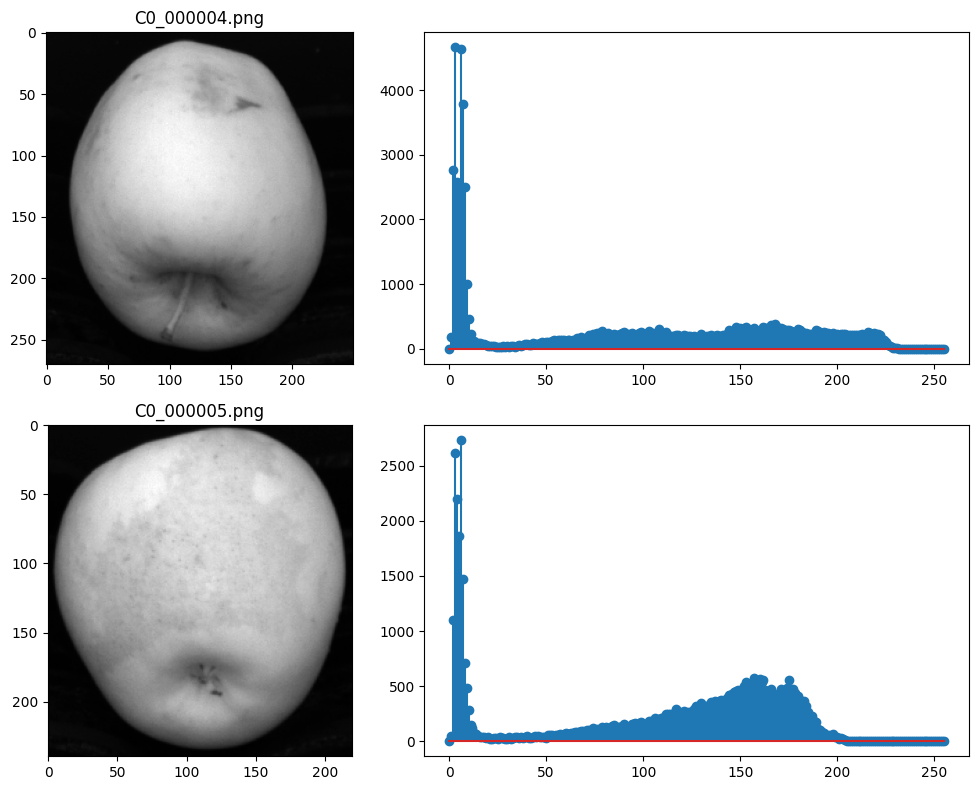

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5]})

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+4}.png")
    axs[i, 1].stem(hist)
    plt.tight_layout()

plt.show()    

We separate the foreground from background in order to compute the space color of fruit.

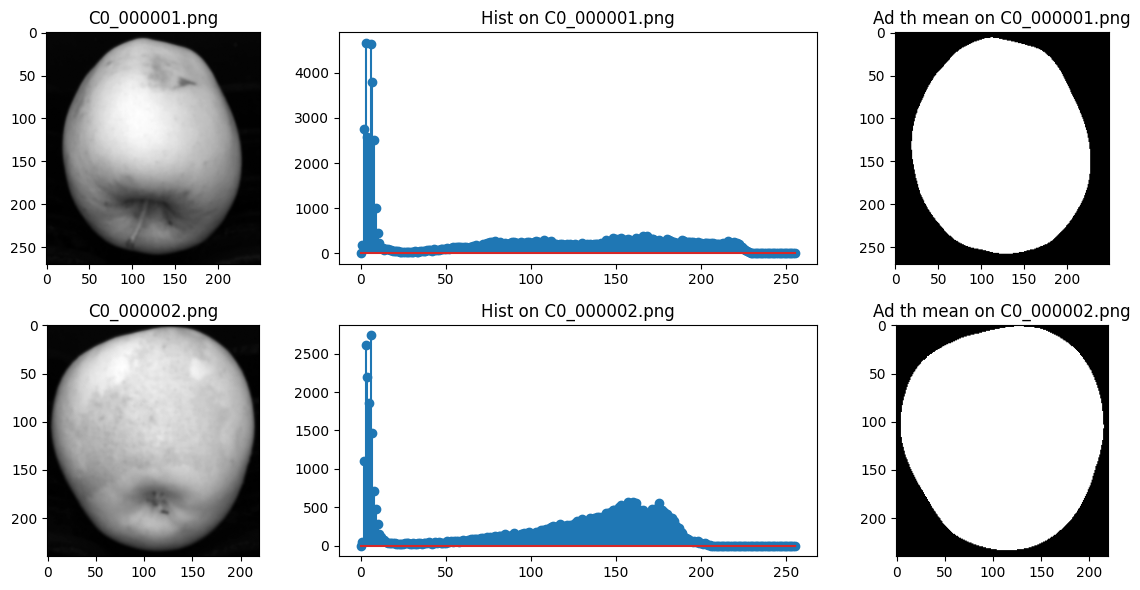

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.5, 1]})
th1_final_arr = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,303,9)

    #fill background
    th1 = np.pad(th1, 1, mode='constant', constant_values=255)
    cv2.floodFill(th1, None, (0, 0), 0)
    th1 = th1[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th1_copy = th1.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th1_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))

    th1_final_arr.append(th1_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(th1_final, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

The first idea was to compute the mean of the fruit color space and then compute the Mahalanobis distance between each pixel and the mean. <br>
The Mahalanobis distance is given by:
$$ d_M(I(p), \mu) = \left( (I(p) - \mu)^T \Sigma^{-1} (I(p) - \mu) \right)^{\frac{1}{2}} $$
Applied to color space, and assuming no cross-channel correlation in RGB — so that the covariance matrix is diagonal — the Mahalanobis distance becomes:
$$ d_M(I(p), \mu) = \left[\frac{(I_r(p) - \mu_r)^2}{\sigma_{rr}^2} + \frac{(I_g(p) - \mu_g)^2}{\sigma_{gg}^2} + \frac{(I_b(p) -\mu_b)^2}{\sigma_{bb}^2} \right]^{\frac{1}{2}} $$
Contrary to the Euclidean distance, the Mahalanobis distance weighs unequally the differences along the components of the random vector, in particular according to inverse proportionality to the learned variances. If a feature varies a lot, Mahalanobis distance will downweight differences along that axis. As such, the more spread has been learned to be a component, the less the difference along it will contribute to the overall distance. 
It is thus necessary to know the reference colour which can be estimated from one or more training images. We can take an image of the first folder with no russet on the apple, compute the mean and the covariance matrix and the use them to compute the Mahalanobis distance on the pixels of the second task images.

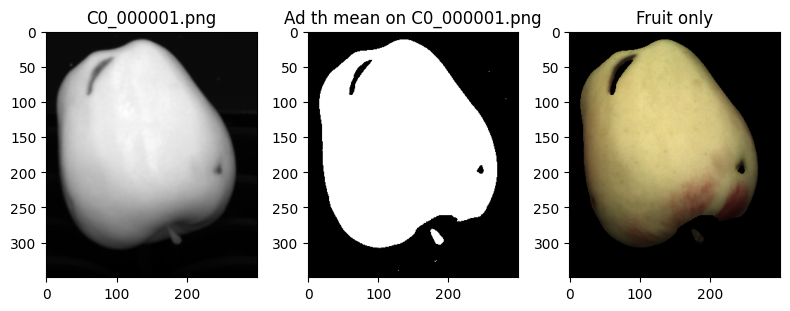

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(8, 8), gridspec_kw={'width_ratios': [1, 1, 1]})

path = f'./fruit-inspection-images/first task/C0_000001.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

path = f'./fruit-inspection-images/first task/C1_000001.png'
img_Luv = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2Luv)
img_HSV = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2HSV)
img_RGB = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

blur = cv2.bilateralFilter(img,5,75,75)
th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,101,9)

#fill background
th1 = np.pad(th1, 1, mode='constant', constant_values=255)
cv2.floodFill(th1, None, (0, 0), 0)
th1 = th1[1:-1, 1:-1]

#Flood-fill the background with 255 (white)
th1_copy = th1.copy()
h, w = img.shape
mask = np.zeros((h+2, w+2), dtype=np.uint8)
cv2.floodFill(th1_copy, mask, (0,0), 255)

#Fill internal holes by overlapping results
#th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))
fruit_only = cv2.bitwise_and(img_colored, img_colored, mask=th1)

axs[0].imshow(blur, cmap='gray'), axs[0].set_title(f"C0_000001.png")
axs[1].imshow(th1, cmap='gray'), axs[1].set_title(f"Ad th mean on C0_000001.png")
axs[2].imshow(cv2.cvtColor(fruit_only, cv2.COLOR_Luv2RGB)), axs[2].set_title(f"Fruit only")
#axs[2].imshow(fruit_only), axs[2].set_title(f"Fruit only")

plt.tight_layout()

plt.show()    

In [17]:
fruit_pixels_Luv = img_Luv[th1 == 255].astype(np.float64)
fruit_pixels_HSV = img_HSV[th1 == 255].astype(np.float64)
fruit_pixels_RGB = img_RGB[th1 == 255].astype(np.float64)

# Make sure it’s 2D (N x D)
if fruit_pixels_Luv.ndim == 1:
    fruit_pixels_Luv = fruit_pixels_Luv.reshape(-1, 1)
if fruit_pixels_HSV.ndim == 1:
    fruit_pixels_HSV = fruit_pixels_HSV.reshape(-1, 1)
if fruit_pixels_RGB.ndim == 1:
    fruit_pixels_RGB = fruit_pixels_RGB.reshape(-1, 1)

# Compute covariance and mean
covar_matrix_Luv, mean_color_Luv = cv2.calcCovarMatrix(
    fruit_pixels_Luv,
    None,
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
covar_matrix_HSV, mean_color_HSV = cv2.calcCovarMatrix(
    fruit_pixels_HSV,
    None,
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
covar_matrix_RGB, mean_color_RGB = cv2.calcCovarMatrix(
    fruit_pixels_RGB,
    None,
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)

# Invert covariance
_, inv_cov_Luv = cv2.invert(covar_matrix_Luv)
_, inv_cov_HSV = cv2.invert(covar_matrix_HSV)
_, inv_cov_RGB = cv2.invert(covar_matrix_RGB)

# Ensure both are 1D float64 arrays
mean_vec_Luv = mean_color_Luv.flatten().astype(np.float64)
mean_vec_HSV = mean_color_HSV.flatten().astype(np.float64)
mean_vec_RGB = mean_color_RGB.flatten().astype(np.float64)

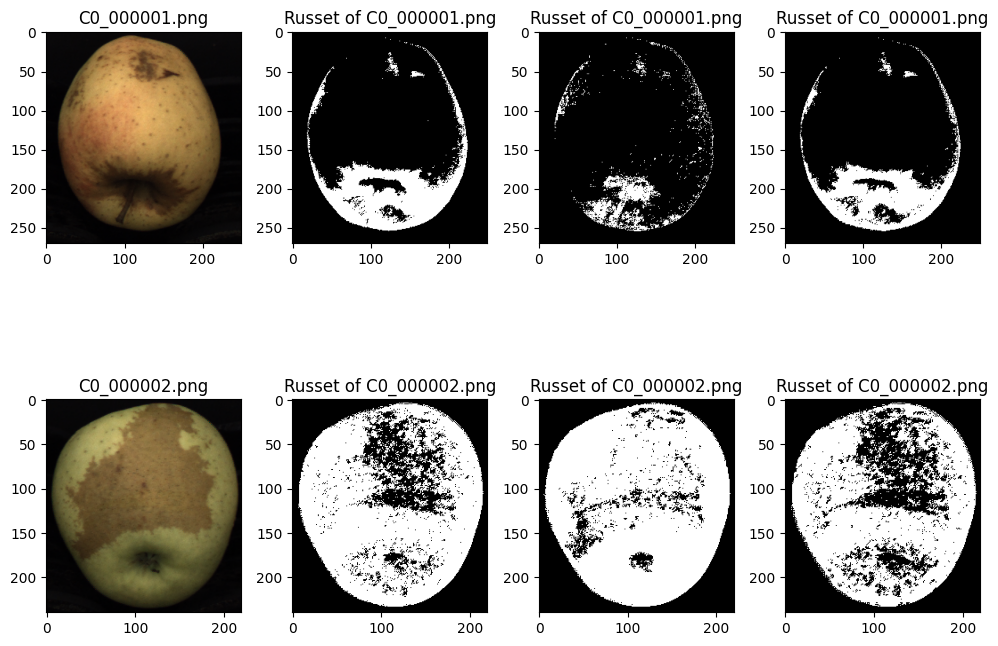

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
russets = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img_Luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Loop through pixels
    russet_mask_Luv = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    russet_mask_HSV = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    russet_mask_RGB = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val_Luv = img_Luv[x, y, :].astype(np.float64).flatten()
                mahal_dist_Luv = cv2.Mahalanobis(pixel_val_Luv, mean_vec_Luv, inv_cov_Luv)

                pixel_val_HSV = img_HSV[x, y, :].astype(np.float64).flatten()
                mahal_dist_HSV = cv2.Mahalanobis(pixel_val_HSV, mean_vec_HSV, inv_cov_HSV)

                pixel_val_RGB = img_RGB[x, y, :].astype(np.float64).flatten()
                mahal_dist_RGB = cv2.Mahalanobis(pixel_val_RGB, mean_vec_RGB, inv_cov_RGB)
                
                if mahal_dist_Luv < 3:
                    russet_mask_Luv[x, y] = 255

                if mahal_dist_HSV < 3:
                    russet_mask_HSV[x, y] = 255

                if mahal_dist_RGB < 3:
                    russet_mask_RGB[x, y] = 255

    #russets.append(russet_mask)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(russet_mask_Luv, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 2].imshow(russet_mask_HSV, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 3].imshow(russet_mask_RGB, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Russet of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

As seen earlier, this solution did not work, probably because of the reference image used. <br>
Another solution is to preprocess russet images and use them as reference images.

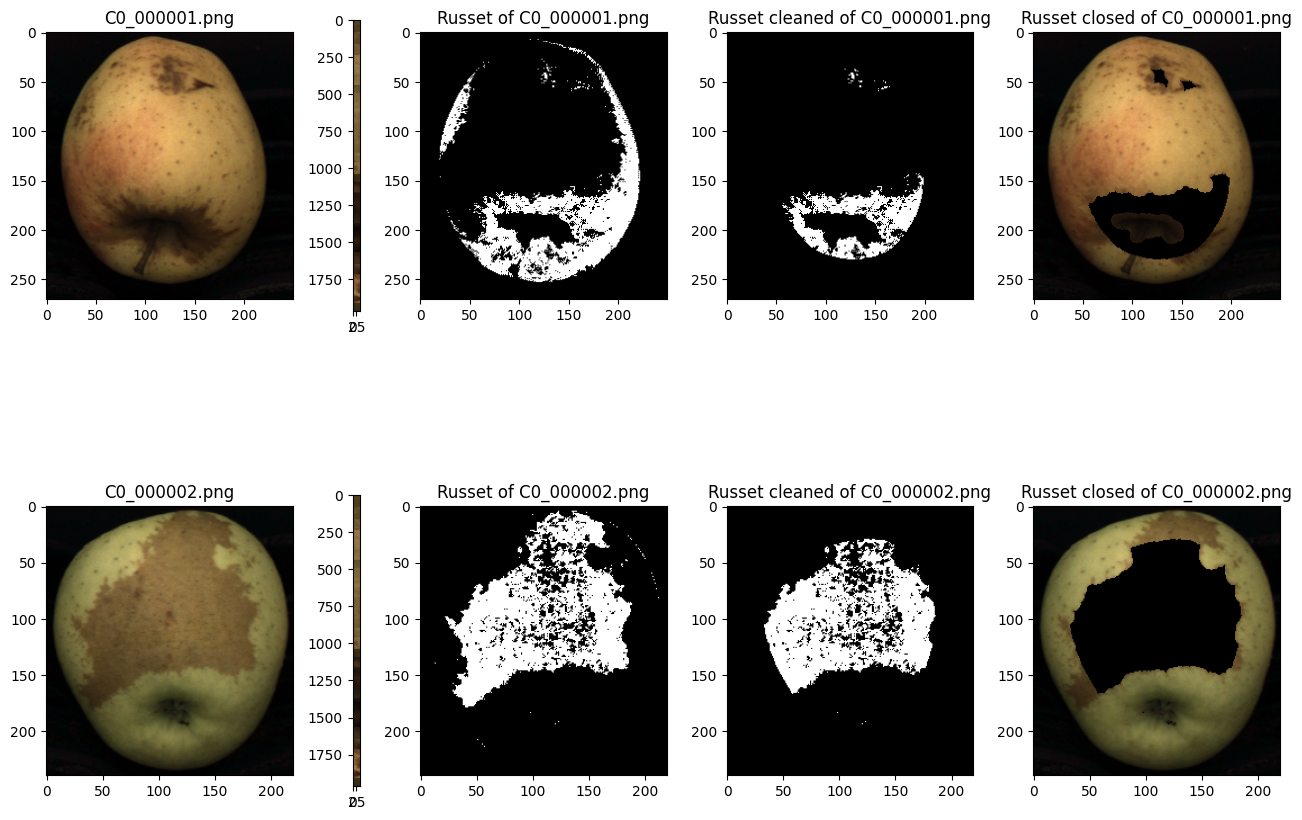

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 0.03, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

for i in range(29):
    path = f'./fruit-inspection-images/second task/samples/sample_{i+1:02d}.png'
    img = cv2.imread(path)
    img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    ref.append(img)

# Find minimum width
w_min = min(img.shape[1] for img in ref)

# Initialize sample matrix
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Concatenate sample images
for img in ref:
    width = img.shape[1] 
    n_subsamples = width // w_min

    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :] 
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Delete first row
sample_matrix = sample_matrix[1:, :, :]

# Take only u and v channels
uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)

# Compute covariance matrix and mean vector
covar_matrix, mean_color = cv2.calcCovarMatrix(
    uv_data, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, 1:3].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 1.3: #after many trial, we found 1.3 as a good value
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Isolate background
    background = 255 - th1_final_arr[i]

    # Apply a dilatation to background
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Subtract background from the russet mask created before (we do this in order to delete that pixel on fruit edges that are darker)
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Apply a closing for the small holes in the mask
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed_russet = cv2.morphologyEx(russet_cleaned, cv2.MORPH_CLOSE, structuring_element)
    final_russets.append(closed_russet)

    # Plot
    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 3].imshow(russet_cleaned, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Russet cleaned of C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cv2.cvtColor(img, cv2.COLOR_Luv2RGB), mask=cv2.bitwise_not(closed_russet)), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

Hoop the russets.

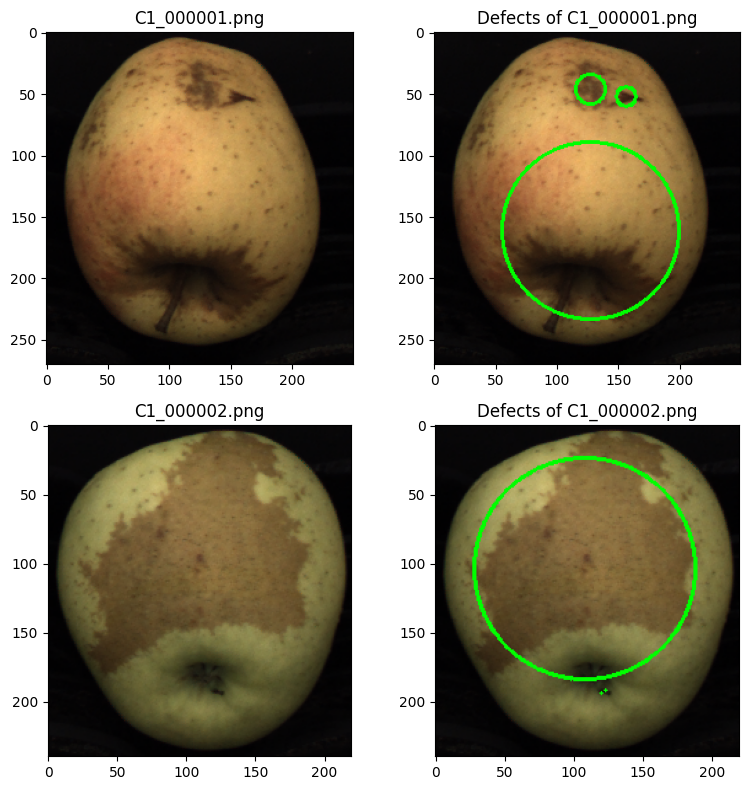

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [1, 1]})
for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #defects = cv2.bitwise_and(image_rgb, image_rgb, mask=cv2.bitwise_not(int_edge_dil_arr[i]))
    defects = image_rgb.copy()

    contours, _ = cv2.findContours(final_russets[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (center_x, center_y), radius = cv2.minEnclosingCircle(contour)
        center = (int(center_x), int(center_y))
        radius = int(radius)
        # Draw on image
        cv2.circle(defects, center, radius, (0, 255, 0), 2)

    #Print images
    axs[i, 0].imshow(image_rgb), axs[i, 0].set_title(f"C1_00000{i+1}.png")
    axs[i, 1].imshow(defects), axs[i, 1].set_title(f"Defects of C1_00000{i+1}.png")

    plt.tight_layout()

ALTRE PROVE:

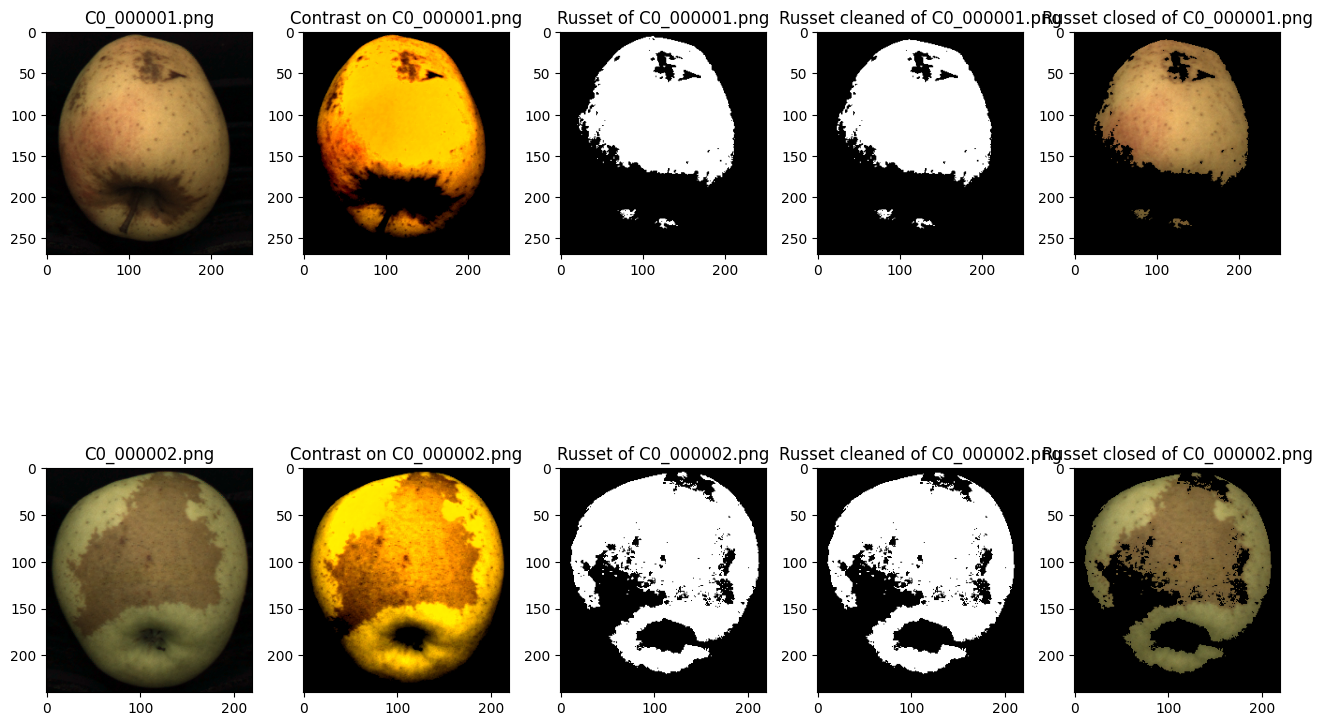

In [45]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

"""alpha = 2.0
beta = 2"""
alpha = 3.0
beta = -150

for i in range(13):
    path = f'./fruit-inspection-images/second task/reference/ref{i+1}.png'
    img = cv2.imread(path)
    img = cv2.GaussianBlur(img,(15,15),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    ref.append(img)

# Trova la larghezza minima tra tutte le immagini
w_min = min(img.shape[1] for img in ref)

# Inizializza la matrice dei campioni con una riga vuota come placeholder
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Costruisci la matrice dei campioni suddividendo e concatenando le immagini
for img in ref:
    width = img.shape[1]  # Larghezza dell'immagine
    n_subsamples = width // w_min  # Numero di sotto-campioni possibili
    
    # Estrai e concatena sotto-campioni di larghezza w_min
    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :]  # Sotto-campione
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Rimuovi la riga iniziale (placeholder)
sample_matrix = sample_matrix[1:, :, :]

# Estrai solo i canali U e V e ridimensiona in una matrice Nx2 così da avere solo celle contenenti i valori u e v.
#uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)
sample_matrix = sample_matrix[:, :, :].reshape(-1, 3)
#print(sample_matrix.shape)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    sample_matrix, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    new_img = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = new_img[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 120: #120-140 for the first image
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Calcola lo sfondo invertendo la segmentazione manuale
    background = 255 - th1_final_arr[i]

    # Dilata lo sfondo per creare un bordo attorno ad esso
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Sottrai lo sfondo dilatato dalla maschera originale dei russet
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Definisci l'elemento strutturante per l'operazione di chiusura
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    # Chiudi eventuali piccoli buchi nella maschera usando MORPH_CLOSE
    #closed_russet = cv2.morphologyEx(russet_mask, cv2.MORPH_CLOSE, structuring_element)
    #final_russets.append(closed_russet)
    
    # Applica la maschera binaria all'immagine HSV originale
    #russets_rgb = highlight_edges(img, final_russets)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(cv2.cvtColor(new_img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Contrast on C0_00000{i+1}.png")
    #axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 3].imshow(russet_cleaned, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Russet cleaned of C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cv2.cvtColor(img, cv2.COLOR_Luv2RGB), mask=russet_cleaned), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

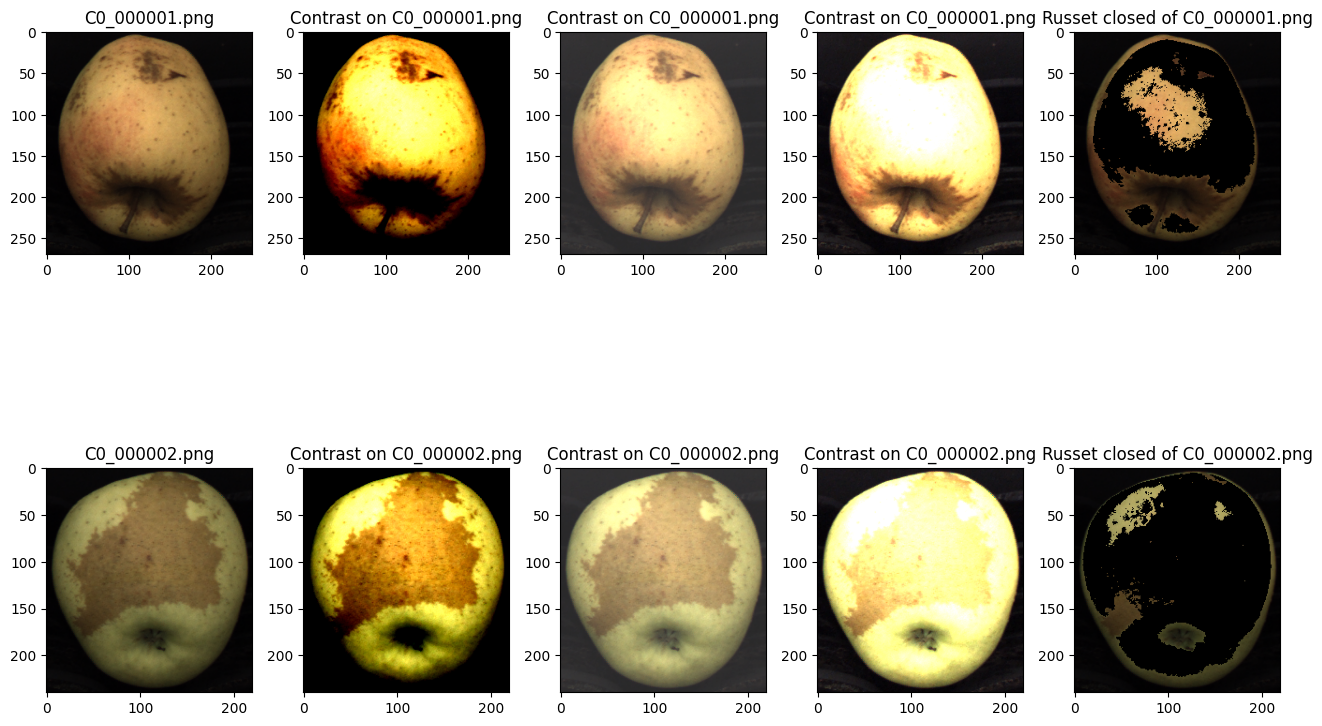

In [60]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

for i in range(13):
    alpha = 1.0
    beta = 0    
    path = f'./fruit-inspection-images/second task/reference/ref{i+1}.png'
    img = cv2.imread(path)

    img1 = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                img1[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
    img1 = cv2.GaussianBlur(img1,(9,9),0)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    ref.append(img1)

# Trova la larghezza minima tra tutte le immagini
w_min = min(img.shape[1] for img in ref)

# Inizializza la matrice dei campioni con una riga vuota come placeholder
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Costruisci la matrice dei campioni suddividendo e concatenando le immagini
for img in ref:
    width = img.shape[1]  # Larghezza dell'immagine
    n_subsamples = width // w_min  # Numero di sotto-campioni possibili
    
    # Estrai e concatena sotto-campioni di larghezza w_min
    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :]  # Sotto-campione
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Rimuovi la riga iniziale (placeholder)
sample_matrix = sample_matrix[1:, :, :]

# Estrai solo i canali U e V e ridimensiona in una matrice Nx2 così da avere solo celle contenenti i valori u e v.
#uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)
sample_matrix = sample_matrix[:, :, :].reshape(-1, 3)
#print(sample_matrix.shape)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    sample_matrix, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    alpha = 3.0
    beta = -150
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    new_img1 = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img1[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    new_img2 = np.zeros(img.shape, img.dtype)
    alpha = 1.3
    beta = 40

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img2[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    new_img3 = np.zeros(img.shape, img.dtype)
    alpha = 3
    beta = 0

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img3[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img1 = cv2.cvtColor(new_img1, cv2.COLOR_BGR2RGB)
    new_img2 = cv2.cvtColor(new_img2, cv2.COLOR_BGR2RGB)
    new_img3 = cv2.cvtColor(new_img3, cv2.COLOR_BGR2RGB)
    
    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = new_img1[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist > 20:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Calcola lo sfondo invertendo la segmentazione manuale
    background = 255 - th1_final_arr[i]

    # Dilata lo sfondo per creare un bordo attorno ad esso
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Sottrai lo sfondo dilatato dalla maschera originale dei russet
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Definisci l'elemento strutturante per l'operazione di chiusura
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    # Chiudi eventuali piccoli buchi nella maschera usando MORPH_CLOSE
    closed_russet = cv2.morphologyEx(russet_mask, cv2.MORPH_CLOSE, structuring_element)
    final_russets.append(closed_russet)
    
    # Applica la maschera binaria all'immagine HSV originale
    #russets_rgb = highlight_edges(img, final_russets)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(new_img1, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Contrast on C0_00000{i+1}.png")
    #axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(new_img2, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Contrast on C0_00000{i+1}.png")
    axs[i, 3].imshow(new_img3, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Contrast on C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(img, img, mask=cv2.bitwise_not(russet_cleaned)), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

In [109]:
path = f'./fruit-inspection-images/second task/C1_000004.png'
img = cv2.imread(path)
#img = cv2.GaussianBlur(img,(9,9),0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Extract masked pixels (each row = pixel vector)
fruit_pixels = img[th1_final_arr[0] == 255].astype(np.float64)

# Make sure it’s 2D (N x D)
if fruit_pixels.ndim == 1:
    fruit_pixels = fruit_pixels.reshape(-1, 1)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    fruit_pixels, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)

print(np.mean(mean_color))

92.12503274394237
